In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## **Data Load & Check**

In [ ]:
import warnings
warnings.filterwarnings("ignore")
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics.pairwise import cosine_similarity
import re
from PIL import Image
import requests
import random
from sklearn.feature_extraction.text import CountVectorizer
import nltk
from nltk.corpus import stopwords

In [ ]:
books=pd.read_csv("/content/drive/MyDrive/255-Project-artifacts/Contentbased/Books.csv")
books.head(3)

,ISBN,Book-Title,Book-Author,Year-Of-Publication,Publisher,Image-URL-S,Image-URL-M,Image-URL-L
0,0195153448,Classical Mythology,Mark P. O. Morford,2002,Oxford University Press,http://images.amazon.com/images/P/0195153448.0...,http://images.amazon.com/images/P/0195153448.0...,http://images.amazon.com/images/P/0195153448.0...
1,0002005018,Clara Callan,Richard Bruce Wright,2001,HarperFlamingo Canada,http://images.amazon.com/images/P/0002005018.0...,http://images.amazon.com/images/P/0002005018.0...,http://images.amazon.com/images/P/0002005018.0...
2,0060973129,Decision in Normandy,Carlo D'Este,1991,HarperPerennial,http://images.amazon.com/images/P/0060973129.0...,http://images.amazon.com/images/P/0060973129.0...,http://images.amazon.com/images/P/0060973129.0...


In [ ]:
users=pd.read_csv("/content/drive/MyDrive/255-Project-artifacts/Contentbased/Users.csv")
users.head(3)

,User-ID,Location,Age
0,1,"nyc, new york, usa",NaN
1,2,"stockton, california, usa",18.0
2,3,"moscow, yukon territory, russia",NaN


In [ ]:
ratings=pd.read_csv("/content/drive/MyDrive/255-Project-artifacts/Contentbased/Ratings.csv")
ratings.head(3)

,User-ID,ISBN,Book-Rating
0,276725,034545104X,0
1,276726,0155061224,5
2,276727,0446520802,0


In [ ]:
print("Books Shape: " ,books.shape )
print("Ratings Shape: " ,ratings.shape )
print("Users Shape: " ,users.shape )

Books Shape:  (271360, 8)
Ratings Shape:  (1149780, 3)
Users Shape:  (278858, 3)


In [ ]:
print("Any null values in Books:\n" ,books.isnull().sum())
print("Any null values in Ratings:\n ",ratings.isnull().sum())
print("Any null values in Users:\n",users.isnull().sum())

Any null values in Books:
 ISBN                   0
Book-Title             0
Book-Author            1
Year-Of-Publication    0
Publisher              2
Image-URL-S            0
Image-URL-M            0
Image-URL-L            3
dtype: int64
Any null values in Ratings:
  User-ID        0
ISBN           0
Book-Rating    0
dtype: int64
Any null values in Users:
 User-ID          0
Location         0
Age         110762
dtype: int64


# **PREPROCESSING**

In [ ]:
books_data=books.merge(ratings,on="ISBN")
books_data.head()

,ISBN,Book-Title,Book-Author,Year-Of-Publication,Publisher,Image-URL-S,Image-URL-M,Image-URL-L,User-ID,Book-Rating
0,0195153448,Classical Mythology,Mark P. O. Morford,2002,Oxford University Press,http://images.amazon.com/images/P/0195153448.0...,http://images.amazon.com/images/P/0195153448.0...,http://images.amazon.com/images/P/0195153448.0...,2,0
1,0002005018,Clara Callan,Richard Bruce Wright,2001,HarperFlamingo Canada,http://images.amazon.com/images/P/0002005018.0...,http://images.amazon.com/images/P/0002005018.0...,http://images.amazon.com/images/P/0002005018.0...,8,5
2,0002005018,Clara Callan,Richard Bruce Wright,2001,HarperFlamingo Canada,http://images.amazon.com/images/P/0002005018.0...,http://images.amazon.com/images/P/0002005018.0...,http://images.amazon.com/images/P/0002005018.0...,11400,0
3,0002005018,Clara Callan,Richard Bruce Wright,2001,HarperFlamingo Canada,http://images.amazon.com/images/P/0002005018.0...,http://images.amazon.com/images/P/0002005018.0...,http://images.amazon.com/images/P/0002005018.0...,11676,8
4,0002005018,Clara Callan,Richard Bruce Wright,2001,HarperFlamingo Canada,http://images.amazon.com/images/P/0002005018.0...,http://images.amazon.com/images/P/0002005018.0...,http://images.amazon.com/images/P/0002005018.0...,41385,0


In [ ]:
books_data['Book-Rating'].value_counts()

0     647294
8      91804
10     71225
7      66402
9      60778
5      45355
6      31687
4       7617
3       5118
2       2375
1       1481
Name: Book-Rating, dtype: int64

In [ ]:
df=books_data.copy()
df.dropna(inplace=True)
df.reset_index(drop=True,inplace=True)
df.drop(columns=["ISBN","Year-Of-Publication","Image-URL-S","Image-URL-M"],axis=1,inplace=True)
df.drop(index=df[df["Book-Rating"]==0].index,inplace=True)
df["Book-Title"]=df["Book-Title"].apply(lambda x: re.sub("[\W_]+"," ",x).strip())
df.head()

,Book-Title,Book-Author,Publisher,Image-URL-L,User-ID,Book-Rating
1,Clara Callan,Richard Bruce Wright,HarperFlamingo Canada,http://images.amazon.com/images/P/0002005018.01.LZZZZZZZ.jpg,8,5
3,Clara Callan,Richard Bruce Wright,HarperFlamingo Canada,http://images.amazon.com/images/P/0002005018.01.LZZZZZZZ.jpg,11676,8
5,Clara Callan,Richard Bruce Wright,HarperFlamingo Canada,http://images.amazon.com/images/P/0002005018.01.LZZZZZZZ.jpg,67544,8
8,Clara Callan,Richard Bruce Wright,HarperFlamingo Canada,http://images.amazon.com/images/P/0002005018.01.LZZZZZZZ.jpg,116866,9
9,Clara Callan,Richard Bruce Wright,HarperFlamingo Canada,http://images.amazon.com/images/P/0002005018.01.LZZZZZZZ.jpg,123629,9


In [ ]:
print(df.shape)
print('Book rating counts:\n',df['Book-Rating'].value_counts().sort_index())

(383838, 6)
Book rating counts:
 1      1481
2      2375
3      5118
4      7617
5     45355
6     31687
7     66401
8     91803
9     60776
10    71225
Name: Book-Rating, dtype: int64


In [ ]:
pd.set_option('display.max_colwidth', None)


In [ ]:
    rating_count=df.groupby("Book-Title").count()["Book-Rating"].reset_index()

    rating_count.rename(columns={"Book-Rating":"NumberOfVotes"},inplace=True)
    
    rating_average=df.groupby("Book-Title")["Book-Rating"].mean().reset_index()
    rating_average.rename(columns={"Book-Rating":"AverageRatings"},inplace=True)
    
    popularBooks=rating_count.merge(rating_average,on="Book-Title")


In [ ]:
popularBooks = popularBooks.sort_values(by=['NumberOfVotes'],ascending=False)

popularBooks.head()

,Book-Title,NumberOfVotes,AverageRatings
109465,The Lovely Bones A Novel,707,8.185290
131333,Wild Animus,581,4.390706
101988,The Da Vinci Code,494,8.439271
115394,The Secret Life of Bees,406,8.477833
111177,The Nanny Diaries A Novel,393,7.437659


# **POPULAR BOOKS**

In [ ]:
def popular_books(df,n=100):
    rating_count=df.groupby("Book-Title").count()["Book-Rating"].reset_index()
    rating_count.rename(columns={"Book-Rating":"NumberOfVotes"},inplace=True)
    
    rating_average=df.groupby("Book-Title")["Book-Rating"].mean().reset_index()
    rating_average.rename(columns={"Book-Rating":"AverageRatings"},inplace=True)
    
    popularBooks=rating_count.merge(rating_average,on="Book-Title")
    
    def weighted_rate(x):
        v=x["NumberOfVotes"]
        R=x["AverageRatings"]
        
        return ((v*R) + (m*C)) / (v+m)
    
    C=popularBooks["AverageRatings"].mean()
    m=popularBooks["NumberOfVotes"].quantile(0.90)
    
    popularBooks=popularBooks[popularBooks["NumberOfVotes"] >=250]
    popularBooks["Popularity"]=popularBooks.apply(weighted_rate,axis=1)
    popularBooks=popularBooks.sort_values(by="Popularity",ascending=False)
    return popularBooks[["Book-Title","NumberOfVotes","AverageRatings","Popularity"]].reset_index(drop=True).head(n)

In [ ]:
n=10
top_ten=pd.DataFrame(popular_books(df,10))
print(top_ten)

fig,ax=plt.subplots(1,10,figsize=(17,5))
fig.suptitle("MOST POPULAR 10 BOOKS",fontsize=40,color="deepskyblue")
for i in range(len(top_ten["Book-Title"].tolist())):
    url=df.loc[df["Book-Title"]==top_ten["Book-Title"].tolist()[i],"Image-URL-L"][:1].values[0]
    img=Image.open(requests.get(url,stream=True).raw)
    ax[i].imshow(img)
    ax[i].axis("off")
    ax[i].set_title("RATING: {} ".format(round(df[df["Book-Title"]==top_ten["Book-Title"].tolist()[i]]["Book-Rating"].mean(),1)),y=-0.20,color="mediumorchid",fontsize=10)
    fig.show()

                                                               Book-Title  \
0                         Harry Potter and the Prisoner of Azkaban Book 3   
1                                                   To Kill a Mockingbird   
2            Harry Potter and the Sorcerer s Stone Harry Potter Paperback   
3                          Harry Potter and the Chamber of Secrets Book 2   
4  Tuesdays with Morrie An Old Man a Young Man and Life s Greatest Lesson   
5                                                 The Secret Life of Bees   
6                                                       The Da Vinci Code   
7                                                The Lovely Bones A Novel   
8                                       The Red Tent Bestselling Backlist   
9                          Where the Heart Is Oprah s Book Club Paperback   

   NumberOfVotes  AverageRatings  Popularity  
0            277        9.043321    9.016348  
1            267        8.977528    8.950773  
2          

In [ ]:
from IPython.display import HTML
from base64 import b64encode

def show_image(path_to_image, width=None, height=None):

    mime_type = None
    path_to_image = path_to_image.lower()

    # More MIME types:
    # https://developer.mozilla.org/en-US/docs/Web/HTTP/Basics_of_HTTP/MIME_types
    if path_to_image.endswith('.jpg') or path_to_image.endswith('.jpeg'):
        mime_type = 'image/jpeg'
    elif path_to_image.endswith('.png'):
        mime_type = 'image/png'
    elif path_to_image.endswith('.gif'):
        mime_type = 'image/gif'
    else:
        raise ValueError('Unknown extension: %s' % (path_to_image))

    img = open(path_to_image, 'rb').read()
    data_url = 'data:image/jpeg;base64,' + b64encode(img).decode()

    width_str = "width='%d'" % (width) if width is not None else ''
    height_str = "height='%d'" % (width) if height is not None else ''

    display(HTML("<img src='%s' %s%s>" % (data_url, width_str, height_str)))

# **CONTENT BASED RECOMMENDATIONS**

In [ ]:
        rating_count=pd.DataFrame(df["Book-Title"].value_counts())
        rare_books=rating_count[rating_count["Book-Title"]==1].index
        common_books=df[~df["Book-Title"].isin(rare_books)]

        

In [ ]:
common_books

,Book-Title,Book-Author,Publisher,Image-URL-L,User-ID,Book-Rating
1,Clara Callan,Richard Bruce Wright,HarperFlamingo Canada,http://images.amazon.com/images/P/0002005018.01.LZZZZZZZ.jpg,8,5
3,Clara Callan,Richard Bruce Wright,HarperFlamingo Canada,http://images.amazon.com/images/P/0002005018.01.LZZZZZZZ.jpg,11676,8
5,Clara Callan,Richard Bruce Wright,HarperFlamingo Canada,http://images.amazon.com/images/P/0002005018.01.LZZZZZZZ.jpg,67544,8
8,Clara Callan,Richard Bruce Wright,HarperFlamingo Canada,http://images.amazon.com/images/P/0002005018.01.LZZZZZZZ.jpg,116866,9
9,Clara Callan,Richard Bruce Wright,HarperFlamingo Canada,http://images.amazon.com/images/P/0002005018.01.LZZZZZZZ.jpg,123629,9
...,...,...,...,...,...,...
1030861,Anthem,Ayn Rand,Caxton Press,http://images.amazon.com/images/P/087004124X.01.LZZZZZZZ.jpg,259589,8
1030862,A Student of Weather,Elizabeth Hay,Counterpoint Press,http://images.amazon.com/images/P/158243123X.01.LZZZZZZZ.jpg,259591,8
1030975,The Two Towers The Lord of the Rings Part 2,J. R. R. Tolkien,Houghton Mifflin,http://images.amazon.com/images/P/0395647398.01.LZZZZZZZ.jpg,259901,10
1031116,Dreamsnake,Vonda N. McIntyre,Houghton Mifflin,http://images.amazon.com/images/P/0395264707.01.LZZZZZZZ.jpg,275318,10


In [ ]:

print ('******rare_books*******\n', rare_books)

print ('******common_books*******\n', common_books)


******rare_books*******
 Index(['Bossic instinct Biblioteca umoristica Mondadori', 'New Birth',
       'Castles Burning a Childs Life In War',
       'Collins Gem Portuguese Dictionary English Portuguese Portuguese English',
       'Cool It Jennifer Jennifer No 5',
       'Search the Dark Todd Charles Inspector Ian Rutledge Novels',
       'ASP MTS ADSI Web Security',
       'Die SÃ Â hne des Sahib Historischer Roman', 'The Morrowind Prophecies',
       'Me Myself I',
       ...
       'How to Make Your Own Furniture', 'You Are My Sunshine',
       'Futility and Other Animals', 'Midair Contemporary American Fiction',
       'Nights in the Gardens of Brooklyn The Collected Stories of Harvey Swados',
       'The Road Less Traveled A New Psychology of Love Traditional Values and Spiritual Growth',
       'Clippings from My Notebook',
       'Facing the Music Stories The Bright Leaf Short Fiction Series 6',
       'No Man Is an Island A Harvest Hbj Book', 'From One to One Hundred'],
      

In [ ]:
            common_books=common_books.drop_duplicates(subset=["Book-Title"])
            common_books.reset_index(inplace=True)
            common_books["index"]=[i for i in range(common_books.shape[0])]
            targets=["Book-Title","Book-Author","Publisher"]
            common_books["all_features"] = [" ".join(common_books[targets].iloc[i,].values) for i in range(common_books[targets].shape[0])]

In [ ]:
common_books["all_features"]

0                                                                                        Clara Callan Richard Bruce Wright HarperFlamingo Canada
1                                                                                              Decision in Normandy Carlo D'Este HarperPerennial
2        Flu The Story of the Great Influenza Pandemic of 1918 and the Search for the Virus That Caused It Gina Bari Kolata Farrar Straus Giroux
3                                                                                                The Kitchen God s Wife Amy Tan Putnam Pub Group
4                           What If The World s Foremost Military Historians Imagine What Might Have Been Robert Cowley Berkley Publishing Group
                                                                          ...                                                                   
47254                                                                                           Watercolor Techniques Tony Couch F

In [ ]:
import re
import nltk

nltk.download('stopwords')

from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
ps = PorterStemmer()

all_stopwords = stopwords.words('english')
all_stopwords.remove('not')
all_stopwords

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


['i',
 'me',
 'my',
 'myself',
 'we',
 'our',
 'ours',
 'ourselves',
 'you',
 "you're",
 "you've",
 "you'll",
 "you'd",
 'your',
 'yours',
 'yourself',
 'yourselves',
 'he',
 'him',
 'his',
 'himself',
 'she',
 "she's",
 'her',
 'hers',
 'herself',
 'it',
 "it's",
 'its',
 'itself',
 'they',
 'them',
 'their',
 'theirs',
 'themselves',
 'what',
 'which',
 'who',
 'whom',
 'this',
 'that',
 "that'll",
 'these',
 'those',
 'am',
 'is',
 'are',
 'was',
 'were',
 'be',
 'been',
 'being',
 'have',
 'has',
 'had',
 'having',
 'do',
 'does',
 'did',
 'doing',
 'a',
 'an',
 'the',
 'and',
 'but',
 'if',
 'or',
 'because',
 'as',
 'until',
 'while',
 'of',
 'at',
 'by',
 'for',
 'with',
 'about',
 'against',
 'between',
 'into',
 'through',
 'during',
 'before',
 'after',
 'above',
 'below',
 'to',
 'from',
 'up',
 'down',
 'in',
 'out',
 'on',
 'off',
 'over',
 'under',
 'again',
 'further',
 'then',
 'once',
 'here',
 'there',
 'when',
 'where',
 'why',
 'how',
 'all',
 'any',
 'both',
 'each

In [ ]:
common_books['all_features'] = common_books['all_features'].str.lower()
common_books['all_features'] = common_books['all_features'].apply(lambda x: re.sub('[^a-z A-Z 0-9-]+', '', x)) 


In [ ]:
common_books['all_features'] = common_books['all_features'].apply(lambda x: " ".join([i for i in x.split() if i not in all_stopwords]) )

In [ ]:
common_books.shape

(47259, 8)

In [ ]:
vectorizer=CountVectorizer()
common_booksVector=vectorizer.fit_transform(common_books["all_features"])
similarity=cosine_similarity(common_booksVector)


NameError: ignored

In [ ]:

print(similarity)

[[1.         0.1490712  0.         ... 0.25197632 0.12598816 0.        ]
 [0.1490712  1.         0.         ... 0.16903085 0.16903085 0.        ]
 [0.         0.         1.         ... 0.         0.         0.        ]
 ...
 [0.25197632 0.16903085 0.         ... 1.         0.71428571 0.        ]
 [0.12598816 0.16903085 0.         ... 0.71428571 1.         0.        ]
 [0.         0.         0.         ... 0.         0.         1.        ]]


In [ ]:
#@title Default title text
bookTitle = 'Life of Pi'

index=common_books[common_books["Book-Title"]==bookTitle]["index"].values[0]
similar_books=list(enumerate(similarity[index]))
similar_booksSorted=sorted(similar_books,key=lambda x:x[1],reverse=True)[1:6]

In [ ]:
            books=[]
            for i in range(len(similar_booksSorted)):      
                books.append(common_books[common_books["index"]==similar_booksSorted[i][0]]["Book-Title"].item())

In [ ]:
print(books)

['The Secret Life of Bees', 'The Weight of Water A Novel Tag Author of Resistance and Strange Fits of Passion', 'Wicked The Life and Times of the Wicked Witch of the West', 'The Diary of Ellen Rimbauer My Life at Rose Red', 'Anne of Green Gables Anne of Green Gables Novels Paperback']


In [ ]:
def content_based(bookTitle):
    bookTitle=str(bookTitle)
    
    if bookTitle in df["Book-Title"].values:
        rating_count=pd.DataFrame(df["Book-Title"].value_counts())
        rare_books=rating_count[rating_count["Book-Title"]<=50].index
        common_books=df[~df["Book-Title"].isin(rare_books)]
        
        if bookTitle in rare_books:
            most_common=pd.Series(common_books["Book-Title"].unique()).sample(3).values
            print("No Recommendations for this Book ☹️ \n ")
            print("YOU MAY TRY: \n ")
            print("{}".format(most_common[0]), "\n")
            print("{}".format(most_common[1]), "\n")
            print("{}".format(most_common[2]), "\n")
        else:
            common_books=common_books.drop_duplicates(subset=["Book-Title"])
            common_books.reset_index(inplace=True)
            common_books["index"]=[i for i in range(common_books.shape[0])]
            targets=["Book-Title","Book-Author","Publisher"]
            common_books["all_features"] = [" ".join(common_books[targets].iloc[i,].values) for i in range(common_books[targets].shape[0])]
            vectorizer=CountVectorizer()
            common_booksVector=vectorizer.fit_transform(common_books["all_features"])
            similarity=cosine_similarity(common_booksVector)
            index=common_books[common_books["Book-Title"]==bookTitle]["index"].values[0]
            similar_books=list(enumerate(similarity[index]))
            similar_booksSorted=sorted(similar_books,key=lambda x:x[1],reverse=True)[1:6]
            books=[]
            for i in range(len(similar_booksSorted)):
                
                books.append(common_books[common_books["index"]==similar_booksSorted[i][0]]["Book-Title"].item())
            fig,ax=plt.subplots(1,5,figsize=(17,5))
            fig.suptitle("YOU MAY ALSO LIKE THESE BOOKS",fontsize=20,color="chocolate")
                
            for i in range(len(books)):
                
                url=common_books.loc[common_books["Book-Title"]==books[i],"Image-URL-L"][:1].values[0]
                #img=Image.open(requests.get(url,stream=True).raw)
                #ax[i].imshow(img)
                ax[i].axis("off")
                ax[i].set_title(books[i], fontsize=15)
                #ax[i].set_title("\n RATING: {}".format(round(df[df["Book-Title"]==books[i]]["Book-Rating"].mean(),1)),y=-0.20,color="mediumorchid",fontsize=22)
                fig.show()

    else:
        print(" COULD NOT FIND ")               
content_based

<function __main__.content_based(bookTitle)>

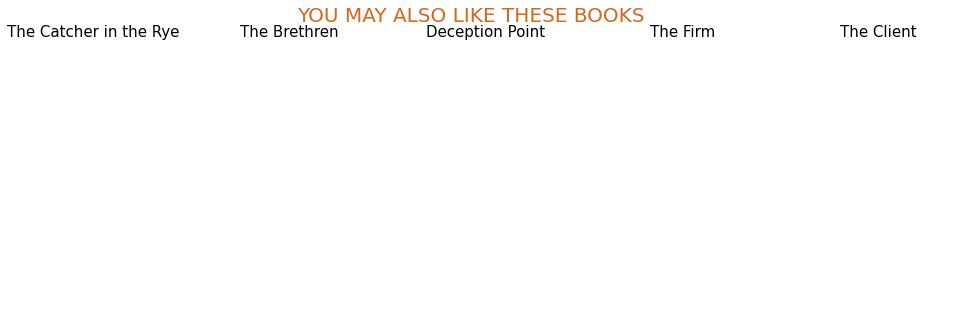

In [ ]:
content_based("The Da Vinci Code")
